In [1]:
import pandas as pd
import numpy as np
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
from functions import plot_z
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
from main import model_0_0, model_0_1, model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10, model_11, model_12, model_13, model_14


class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

/Users/satoshan/.pyenv/versions/miniforge3-4.10.3-10/envs/forpymc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## Real data
### Period 
1983-2018 Q
### Output gap
Beveridge-Nelson Filter (https://bnfiltering.com)

### Inflation Expectation
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)

one year inflation expectation
### Inflation rate
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

---

In [2]:
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()

data_gap = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_gap['Y'] = data_gap["cycle"]
data_gap['DATE'] = data_gap["date"]
data_gap = data_gap[["DATE", "Y"]]

data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]

data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])
data_gap['DATE'] = pd.to_datetime(data_gap['DATE'])
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])


data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_gap, on="DATE", how="outer")
data["pi_prev"] = data["pi"].shift(1)
data["Y_prev"] = data["Y"].shift(1)
data.dropna(inplace=True)
# data = data[data['DATE'] < '2008-07-01']

# for MCMC
pi = jnp.array(data['pi'])
pi_prev = jnp.array(data['pi_prev'])
pi_expect = jnp.array(data['Epi'])
Y = jnp.array(data['Y'])
Y_prev = jnp.array(data['Y_prev'])

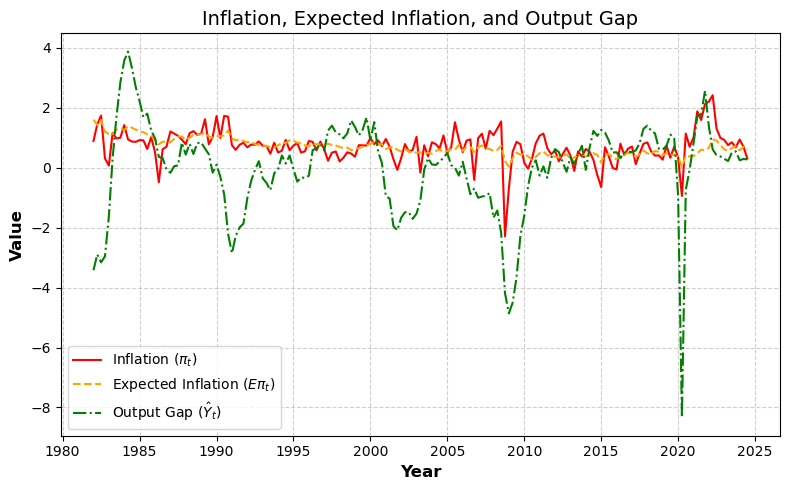

In [3]:
# data
plt.figure(figsize=(8, 5))
plt.plot(data["DATE"], data["pi"], label=r'Inflation $(\pi_{t})$', linestyle='-', color='red')       
plt.plot(data["DATE"], data["Epi"], label=r'Expected Inflation $(E\pi_{t})$', linestyle='--', color='orange')    
plt.plot(data["DATE"], data["Y"], label='Output Gap $(\hat{Y}_{t})$', linestyle='-.', color='green') 
plt.xlabel('Year', fontsize=12, weight='bold')
plt.ylabel('Value', fontsize=12, weight='bold')
plt.title('Inflation, Expected Inflation, and Output Gap', fontsize=14)
plt.legend(fontsize=10, frameon=True, loc='lower left', fancybox=True)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

####  Model

"COMPETITION AND THE PHILLIPS CURVE"

Ippei Fujiwara and Kiminori Matsuyama

NKPC in terms of the output gap is given by:

$$
\hat{\pi}_t 
= \beta E_t[\hat{\pi}_{t+1}]
  \;+\;\kappa(z)\,\hat{Y}_t
  \;-\;\frac{\zeta(z) - 1}{\chi}\,\frac{1 - \rho(z)}{\rho(z)}\,\hat{z}_t,
$$

where

$$
\kappa(z)
:= \frac{\zeta(z) - 1}{\chi}
   \,\frac{1}{1 + \psi}
   \,\frac{
       (\sigma + \psi)
       \;-\;\bigl(1 - \sigma\bigr)\,\dfrac{1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }{
       1
       \;-\;\dfrac{\zeta(z) - 1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }.
$$

## Estimation

The observed variable $\pi_t$ is the inflation rate, $\text{E}\pi_t$ is the expected inflation rate, and $\text{gap}_t$ is the output gap


In [4]:
warmup= 15000
samples=10000
chains = 2
rng_key = jax.random.PRNGKey(0)

In [5]:
# RUN MCMC
kernel = NUTS(model_0_0)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y)
idata_0_0 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
model_0_0_kappa = posterior_samples["kappa"].mean()
model_0_0_beta = posterior_samples["beta"].mean()
result_0_0=rf"""
Result $$\pi_{{t}} = {model_0_0_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_0_0_kappa:.4f}\, Y_t + \epsilon_t$$
"""
display(Markdown(result_0_0))

# RUN MCMC
kernel = NUTS(model_0_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y)
idata_0_1 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
model_0_1_kappa  = posterior_samples["kappa"].mean()
model_0_1_beta = posterior_samples["beta"].mean()
model_0_1_alpha = posterior_samples["alpha"].mean()

result_0_1=rf"""
Result $$\pi_{{t}} = {model_0_1_alpha:.4f}\, \pi_{{t-1}} + {model_0_1_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_0_1_kappa:.4f}\, Y_t + \epsilon_t$$
"""
display(Markdown(result_0_1))

sample: 100%|██████████| 25000/25000 [00:03<00:00, 7633.93it/s, 7 steps of size 4.33e-01. acc. prob=0.93]



Result $$\pi_{t} = 0.9604\, E_t[\pi_{t+1}] + 0.0655\, Y_t + \epsilon_t$$


sample: 100%|██████████| 25000/25000 [00:02<00:00, 8354.82it/s, 7 steps of size 5.70e-01. acc. prob=0.93] 



Result $$\pi_{t} = 0.2369\, \pi_{t-1} + 0.7631\, E_t[\pi_{t+1}] + 0.0620\, Y_t + \epsilon_t$$


In [6]:
# RUN MCMC
kernel = NUTS(model_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_1 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_1 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_1 = z_mean_1 - 1.96 * z_std     
z_upper_1 = z_mean_1 + 1.96 * z_std  

model_1_kappa = posterior_samples["kappa"].mean()
model_1_theta = posterior_samples["theta"].mean()
model_1_beta  = posterior_samples["beta"].mean()
model_1_gamma  = posterior_samples["gamma"].mean()

result_1=rf"""
Result $$\pi_{{t}} = {model_1_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_1_kappa:.4f}\, Y_t - {model_1_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_1_gamma:.4f}  z_{{t-1}} + \eta_t$$
"""
display(Markdown(result_1))

# RUN MCMC
kernel = NUTS(model_2)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_2 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_2 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_2 = z_mean_2 - 1.96 * z_std     
z_upper_2 = z_mean_2 + 1.96 * z_std    

model_2_kappa = posterior_samples["kappa"].mean()
model_2_alpha = posterior_samples["alpha"].mean()
model_2_theta = posterior_samples["theta"].mean()
model_2_beta = posterior_samples["beta"].mean()
model_2_gamma = posterior_samples["gamma"].mean()

result_2=rf"""
Result $$\pi_{{t}} = {model_2_alpha:.4f}\, \pi_{{t-1}} + {model_2_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_2_kappa:.4f}\, Y_t - {model_2_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_2_gamma:.4f}  z_{{t-1}} + \eta_t$$
"""
display(Markdown(result_2))

sample: 100%|██████████| 25000/25000 [00:12<00:00, 2064.66it/s, 63 steps of size 6.56e-02. acc. prob=0.79] 



Result $$\pi_{t} = 0.9534\, E_t[\pi_{t+1}] + 0.1036\, Y_t - 0.2517\, z_t + \epsilon_t$$
$$z_{t} = 0.5845  z_{t-1} + \eta_t$$


sample: 100%|██████████| 25000/25000 [00:12<00:00, 2030.08it/s, 63 steps of size 7.54e-02. acc. prob=0.76] 



Result $$\pi_{t} = 0.0361\, \pi_{t-1} + 0.9639\, E_t[\pi_{t+1}] + 0.0967\, Y_t - 0.2786\, z_t + \epsilon_t$$
$$z_{t} = 0.5845  z_{t-1} + \eta_t$$


In [7]:
# RUN MCMC
kernel = NUTS(model_3)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_3 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_3 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_3 = z_mean_3 - 1.96 * z_std     
z_upper_3 = z_mean_3 + 1.96 * z_std  

model_3_kappa = posterior_samples["kappa"].mean()
model_3_theta = posterior_samples["theta"].mean()
model_3_beta = posterior_samples["beta"].mean()
model_3_rho = posterior_samples["rho"].mean()

result_3=rf"""
Result $$\pi_{{t}} = {model_3_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_3_kappa:.4f}\, Y_t - {model_3_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_3_rho:.4f}  Y_{{t-1}} + \eta_t$$
"""
display(Markdown(result_3))

# RUN MCMC
kernel = NUTS(model_4)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_4 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]

z_mean_4 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_4 = z_mean_4 - 1.96 * z_std     
z_upper_4 = z_mean_4 + 1.96 * z_std  

model_4_alpha = posterior_samples["alpha"].mean()
model_4_kappa = posterior_samples["kappa"].mean()
model_4_theta = posterior_samples["theta"].mean()
model_4_beta = posterior_samples["beta"].mean()
model_4_rho = posterior_samples["rho"].mean()

result_4=rf"""
Result $$\pi_{{t}} = {model_4_alpha:.4f}\, \pi_{{t-1}} + {model_4_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_4_kappa:.4f}\, Y_t - {model_4_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_4_rho:.4f}  Y_{{t-1}} + \eta_t$$
"""
display(Markdown(result_4))

sample: 100%|██████████| 25000/25000 [00:15<00:00, 1603.03it/s, 63 steps of size 4.80e-02. acc. prob=0.81] 



Result $$\pi_{t} = 0.9598\, E_t[\pi_{t+1}] + 0.0960\, Y_t - 0.2295\, z_t + \epsilon_t$$
$$z_{t} = 0.1831  Y_{t-1} + \eta_t$$


sample: 100%|██████████| 25000/25000 [00:16<00:00, 1526.00it/s, 63 steps of size 4.10e-02. acc. prob=0.88] 



Result $$\pi_{t} = 0.2816\, \pi_{t-1} + 0.7184\, E_t[\pi_{t+1}] + 0.1202\, Y_t - 0.3138\, z_t + \epsilon_t$$
$$z_{t} = 0.2693  Y_{t-1} + \eta_t$$


In [8]:
# RUN MCMC
kernel = NUTS(model_5)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_5 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_5 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_5 = z_mean_5 - 1.96 * z_std     
z_upper_5 = z_mean_5 + 1.96 * z_std  

model_5_kappa = posterior_samples["kappa"].mean()
model_5_theta = posterior_samples["theta"].mean()
model_5_beta = posterior_samples["beta"].mean()
model_5_gamma = posterior_samples["gamma"].mean()
model_5_rho = posterior_samples["rho"].mean()

result_5=rf"""
Result $$\pi_{{t}} = {model_5_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_5_kappa:.4f}\, Y_t - {model_5_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} =  {model_5_rho:.4f}  Y_{{t-1}} + {model_5_gamma:.4f}  z_{{t-1}} + \eta_t$$
"""
display(Markdown(result_5))

# RUN MCMC
kernel = NUTS(model_6)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_6 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_6 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_6 = z_mean_6 - 1.96 * z_std     
z_upper_6 = z_mean_6 + 1.96 * z_std  

model_6_alpha = posterior_samples["alpha"].mean()
model_6_kappa = posterior_samples["kappa"].mean()
model_6_theta = posterior_samples["theta"].mean()
model_6_beta = posterior_samples["beta"].mean()
model_6_gamma = posterior_samples["gamma"].mean()
model_6_rho = posterior_samples["rho"].mean()

result_6=rf"""
Result $$\pi_{{t}} = {model_6_alpha:.4f}\, \pi_{{t-1}} + {model_6_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_6_kappa:.4f}\, Y_t - {model_6_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_6_rho:.4f}  Y_{{t-1}} + {model_6_gamma:.4f}  z_{{t-1}} + \eta_t$$
"""
display(Markdown(result_6))

sample: 100%|██████████| 25000/25000 [00:14<00:00, 1772.54it/s, 63 steps of size 6.22e-02. acc. prob=0.77] 



Result $$\pi_{t} = 0.9558\, E_t[\pi_{t+1}] + 0.1266\, Y_t - 0.2381\, z_t + \epsilon_t$$
$$z_{t} =  0.1681  Y_{t-1} + 0.5121  z_{t-1} + \eta_t$$


sample: 100%|██████████| 25000/25000 [00:13<00:00, 1889.97it/s, 2 steps of size 7.03e-02. acc. prob=0.72]  



Result $$\pi_{t} = 0.0549\, \pi_{t-1} + 0.9451\, E_t[\pi_{t+1}] + 0.1238\, Y_t - 0.2536\, z_t + \epsilon_t$$
$$z_{t} = 0.1791  Y_{t-1} + 0.4593  z_{t-1} + \eta_t$$


In [9]:
# RUN MCMC
kernel = NUTS(model_7)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_7 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_7 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_7 = z_mean_7 - 1.96 * z_std     
z_upper_7 = z_mean_7 + 1.96 * z_std  

model_7_kappa = posterior_samples["kappa"].mean()
model_7_beta = posterior_samples["beta"].mean()
model_7_theta = posterior_samples["theta"].mean()
model_7_gamma = posterior_samples["gamma"].mean()
model_7_delta = posterior_samples["delta"].mean()
model_7_rho = posterior_samples["rho"].mean()

result_7=rf"""
Result $$\pi_{{t}} = {model_7_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_7_kappa:.4f}\, Y_t - {model_7_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_7_rho:.4f}  Y_{{t-1}} + {model_7_gamma:.4f}  z_{{t-1}} + {model_7_delta:.4f}  \pi_{{t-1}} + \eta_t$$
"""
display(Markdown(result_7))

# RUN MCMC
kernel = NUTS(model_8)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_8 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_8 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_8 = z_mean_8 - 1.97 * z_std     
z_upper_8 = z_mean_8 + 1.97 * z_std  

model_8_alpha = posterior_samples["alpha"].mean()
model_8_kappa = posterior_samples["kappa"].mean()
model_8_beta = posterior_samples["beta"].mean()
model_8_theta = posterior_samples["theta"].mean()
model_8_gamma = posterior_samples["gamma"].mean()
model_8_rho = posterior_samples["rho"].mean()
model_8_delta = posterior_samples["delta"].mean()

result_8=rf"""
Result $$\pi_{{t}} = {model_8_alpha:.4f}\, \pi_{{t-1}} + {model_8_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_8_kappa:.4f}\, Y_t - {model_8_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_8_rho:.4f}  Y_{{t-1}} + {model_8_gamma:.4f}  z_{{t-1}} + {model_8_delta:.4f}  \pi_{{t-1}} + \eta_t$$
"""
display(Markdown(result_8))

sample: 100%|██████████| 25000/25000 [00:12<00:00, 2057.85it/s, 6 steps of size 9.13e-02. acc. prob=0.55]  



Result $$\pi_{t} = 0.9584\, E_t[\pi_{t+1}] + 0.1248\, Y_t - 0.1822\, z_t + \epsilon_t$$
$$z_{t} = 0.1687  Y_{t-1} + 0.5363  z_{t-1} + 0.1568  \pi_{t-1} + \eta_t$$


sample: 100%|██████████| 25000/25000 [00:12<00:00, 1986.93it/s, 31 steps of size 8.69e-02. acc. prob=0.77] 



Result $$\pi_{t} = 0.0584\, \pi_{t-1} + 0.9416\, E_t[\pi_{t+1}] + 0.1234\, Y_t - 0.2113\, z_t + \epsilon_t$$
$$z_{t} = 0.1850  Y_{t-1} + 0.5055  z_{t-1} + 0.1460  \pi_{t-1} + \eta_t$$


In [10]:
model_0_0_text = r"""--- 
$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t  + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
"""
model_0_1_text = r"""---
$$\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
"""
model_1_text = r"""---
$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \gamma z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_2_text = r"""---
$$\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \gamma z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_3_text = r"""---
$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_4_text = r"""---
$$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_5_text = r"""---
$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_6_text = r"""---
$$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_7_text = r"""---
$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \delta \pi_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""
model_8_text = r"""---
$$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \delta \pi_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
"""

dict_eq = {'Model-0-1':model_0_0_text,'Model-0-2':model_0_1_text,'Model-1':model_1_text, 'Model-2':model_2_text,'Model-3':model_3_text, 'Model-4':model_4_text,
           'Model-5':model_5_text,'Model-6':model_6_text, 'Model-7':model_7_text,'Model-8':model_8_text                                                                                                                                                         }

even_items = []  
odd_items = []   

for model_name, eq_text in dict_eq.items():
    eq_text_escaped = eq_text.replace("|", "\\|")
    eq_text_escaped = eq_text_escaped.replace("\n", "<br>")
    eq_text_escaped = eq_text_escaped.replace("---", "")
    eq_text_escaped = eq_text_escaped.replace("model", "")
    eq_text_escaped = eq_text_escaped.replace("Model", "")
    
    parts = model_name.split('-')
    last_part = parts[-1]
    try:
        number = int(last_part)
    except ValueError:
        number = None
    
    if number is not None and number % 2 == 0:
        even_items.append((model_name, eq_text_escaped))
    else:
        odd_items.append((model_name, eq_text_escaped))

markdown_lines = [
    "| Model | Model(Backward) |",
    "|-----------|-----------|"
]

max_rows = max(len(even_items), len(odd_items))
for i in range(max_rows):
    even_cell = ""
    odd_cell = ""
    if i < len(odd_items):
        odd_model_name, odd_eq = odd_items[i]
        odd_cell = f"**{odd_model_name}**<br>{odd_eq}"
    if i < len(even_items):
        even_model_name, even_eq = even_items[i]
        even_cell = f"**{even_model_name}**<br>{even_eq}"
    markdown_lines.append(f"| {odd_cell} | {even_cell} |")

markdown_table = "\n".join(markdown_lines)
display(Markdown(markdown_table))

| Model | Model(Backward) |
|-----------|-----------|
| **Model-0-1**<br> <br>$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t  + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br> | **Model-0-2**<br><br>$$\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br> |
| **Model-1**<br><br>$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \gamma z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> | **Model-2**<br><br>$$\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \gamma z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> |
| **Model-3**<br><br>$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> | **Model-4**<br><br>$$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> |
| **Model-5**<br><br>$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> | **Model-6**<br><br>$$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> |
| **Model-7**<br><br>$$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \delta \pi_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> | **Model-8**<br><br>$$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$<br>$$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t-1} + \delta \pi_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$<br> |

## Model Comparison

WAIC（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$


$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \gamma z_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$


,model,kappa,beta,alpha,rho,gamma,delta,corr_Y_z_mean
0,Model-0-1,0.065,0.960,-,-,-,-,-
1,Model-0-2,0.062,0.763,0.237,-,-,-,-
2,Model-1,0.104,0.953,-,-,0.584,-,0.205235
3,Model-2,0.097,0.964,0.036,-,0.584,-,0.197092
4,Model-3,0.096,0.960,-,0.183,-,-,0.426465
5,Model-4,0.120,0.718,0.282,0.269,-,-,0.545545
6,Model-5,0.127,0.956,-,0.168,0.512,-,0.26724
7,Model-6,0.124,0.945,0.055,0.179,0.459,-,0.272453
8,Model-7,0.125,0.958,-,0.169,0.536,0.157,0.252214
9,Model-8,0.123,0.942,0.058,0.185,0.506,0.146,0.287118


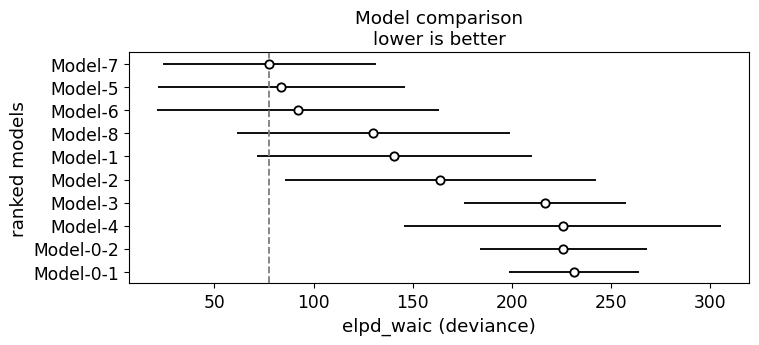

In [11]:
import re
dict_idata = {'Model-0-1':idata_0_0,'Model-0-2':idata_0_1,'Model-1':idata_1, 'Model-2':idata_2,
              'Model-3':idata_3, 'Model-4':idata_4, 'Model-5':idata_5,'Model-6':idata_6, 
               'Model-7':idata_7,'Model-8':idata_8}
df_waic = az.compare(dict_idata, ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(8, 3));
def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None

text = r"""
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \gamma z_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(text))
params = ["kappa", "beta",  "alpha", "rho", "gamma", "delta"]

df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            row[param] = summary.loc[param, "mean"]
        else:
            row[param] = "-"
    
    if "z" in available_params:
        z_samples = idata.posterior["z"].values 
        z_mean = z_samples.mean(axis=(0, 1))     
        corr = np.corrcoef(Y, z_mean)[0, 1]
        row["corr_Y_z_mean"] = corr
    else:
        row["corr_Y_z_mean"] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)



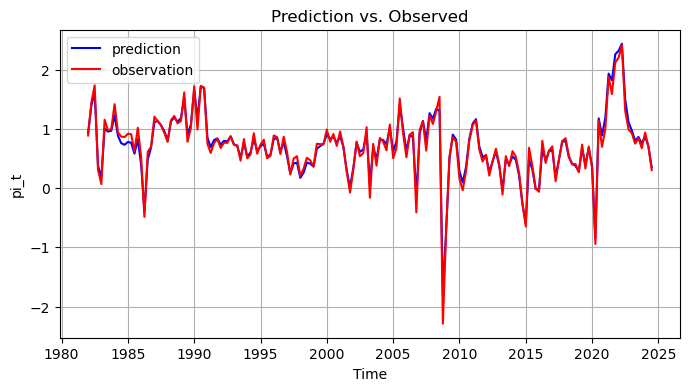

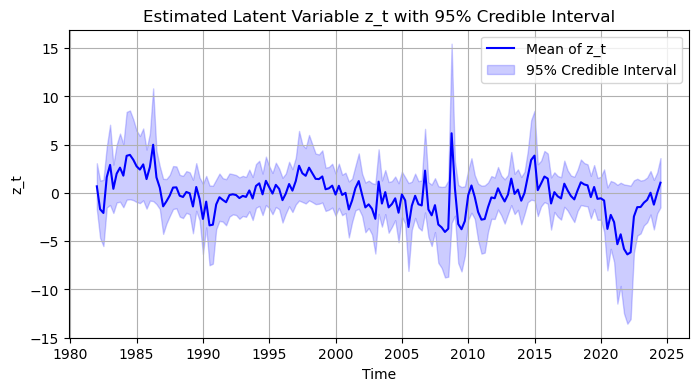

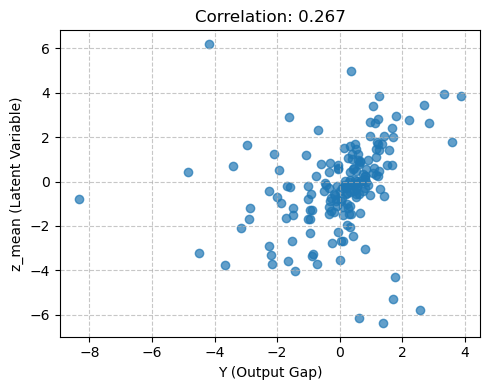

In [12]:
model_number = 5
idata = globals()[f"idata_{model_number}"]
z_mean_value =  globals()[f"z_mean_{model_number}"]
z_lower =  globals()[f"z_lower_{model_number}"]
z_upper =  globals()[f"z_upper_{model_number}"]
if "theta" in idata.posterior.data_vars:
    theta_mean_value = float(idata.posterior["theta"].mean(dim=["chain", "draw"]))
else:
    theta = 0
if "alpha" in idata.posterior.data_vars:
    alpha_mean_value = float(idata.posterior["alpha"].mean(dim=["chain", "draw"]))
else:
    alpha_mean_value = 0
beta_mean_value  = float(idata.posterior["beta"].mean(dim=["chain", "draw"]))
kappa_mean_value = float(idata.posterior["kappa"].mean(dim=["chain", "draw"]))

pi_pred = alpha_mean_value * pi_prev + beta_mean_value * pi_expect + kappa_mean_value * Y - theta_mean_value * z_mean_value

var_pi_pred  = np.var(pi_pred)
var_pi_resid = np.var(pi - pi_pred)
r2 = var_pi_pred / (var_pi_pred + var_pi_resid)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(data["DATE"], pi_pred, label="prediction", color="blue")
plt.plot(data["DATE"], pi, label="observation", color="red")
plt.title("Prediction vs. Observed")
plt.xlabel("Time")
plt.ylabel("pi_t")
plt.legend()
plt.grid(True)
plt.show()

# print(f"Bayesian R^2: {r2}")

plot_z(data["DATE"],z_mean_value,z_lower, z_upper, Y)


## Is NKPC Flattening?

In [13]:


data["DATE"] = pd.to_datetime(data["DATE"])
# periods = [(f"{year}-01-01", f"{year+10}-01-01") for year in range(1984, 2024, 10)]
periods = [
    ('1982-01-01', '1997-04-01'),
    ('1982-01-01', '2007-04-01'),
    ('1982-01-01', '2017-04-01')
]

results_model_0_1 = []
results_model_8   = []

for start, end in periods:
    # data
    df = data[(data["DATE"] >= start) & (data["DATE"] < end)]
    pi        = jnp.array(df["pi"])
    pi_prev   = jnp.array(df["pi_prev"])
    pi_expect = jnp.array(df["Epi"])
    Y         = jnp.array(df["Y"])
    label = f"{start[:4]}-{int(start[:4])+4}"
    # Normal
    kernel = NUTS(model_0_1)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
    mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y)
    posterior_samples = mcmc.get_samples()
    kappa_0_1 = posterior_samples["kappa"].mean()
    results_model_0_1.append((label, kappa_0_1))
    
    # HSA
    kernel = NUTS(model_8)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
    mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
    posterior_samples = mcmc.get_samples()
    kappa_8 = posterior_samples["kappa"].mean()
    results_model_8.append((label, kappa_8))

periods_years = [f"{start[:4]}-{end[:4]}" for start, end in periods]
kappas_0_1 = []
kappas_8   = []
for (label, kappa0), (_, kappa8) in zip(results_model_0_1, results_model_8):
    end_year = int(label[-4:])
    kappas_0_1.append(kappa0)
    kappas_8.append(kappa8)

result = pd.DataFrame({
    "Periods": periods_years,
    "κ (Normal NKPC: model_0_1)": kappas_0_1,
    "κ (HSA NKPC: model_8)": kappas_8
})

result

sample: 100%|██████████| 25000/25000 [00:10<00:00, 2345.33it/s, 2 steps of size 9.06e-02. acc. prob=0.47] 


,Periods,κ (Normal NKPC: model_0_1),κ (HSA NKPC: model_8)
0,1982-1997,0.035961695,0.057373706
1,1982-2007,0.029024294,0.04261925
2,1982-2017,0.034424286,0.064354695


## Comments

- Compared to normal NKPC, our models tend to fit better with the data.

- The correlation between Z(price) and Y(inverse of markup) is weak positive.

- $cov(\mu , N)<0$　→ $cov(\mu , N)>0$ → $cov(Y , N)>0$ → $cov(Y , Z)>0$

- Do we need more information about the structure of z?

- z goes different way at the financial crisis and covid-19.

In [14]:
# model_9_text = r"""---
# $$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
# $$z_t = \rho \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
# """
# model_10_text = r"""---
# $$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
# $$z_t = \rho \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
# """
# model_11_text = r"""---
# $$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
# $$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
# """
# model_12_text = r"""---
# $$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
# $$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
# """
# model_13_text = r"""---
# $$\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
# $$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t} + \delta \pi_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
# """
# model_14_text = r"""---
# $$\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$$
# $$z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{t} + \delta \pi_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$
# """


# dict_eq = {'Model-9':model_9_text, 'Model-10':model_10_text, 'Model-11':model_11_text, 'Model-12':model_12_text,'Model-13':model_13_text, 'Model-14':model_14_text}

# even_items = []  
# odd_items = []   

# for model_name, eq_text in dict_eq.items():
#     eq_text_escaped = eq_text.replace("|", "\\|")
#     eq_text_escaped = eq_text_escaped.replace("\n", "<br>")
#     eq_text_escaped = eq_text_escaped.replace("---", "")
#     eq_text_escaped = eq_text_escaped.replace("model", "")
#     eq_text_escaped = eq_text_escaped.replace("Model", "")
    
#     parts = model_name.split('-')
#     last_part = parts[-1]
#     try:
#         number = int(last_part)
#     except ValueError:
#         number = None
    
#     if number is not None and number % 2 == 0:
#         even_items.append((model_name, eq_text_escaped))
#     else:
#         odd_items.append((model_name, eq_text_escaped))

# markdown_lines = [
#     "| Model | Model(Backward) |",
#     "|-----------|-----------|"
# ]

# max_rows = max(len(even_items), len(odd_items))
# for i in range(max_rows):
#     even_cell = ""
#     odd_cell = ""
#     if i < len(odd_items):
#         odd_model_name, odd_eq = odd_items[i]
#         odd_cell = f"**{odd_model_name}**<br>{odd_eq}"
#     if i < len(even_items):
#         even_model_name, even_eq = even_items[i]
#         even_cell = f"**{even_model_name}**<br>{even_eq}"
#     markdown_lines.append(f"| {odd_cell} | {even_cell} |")

# markdown_table = "\n".join(markdown_lines)
# display(Markdown(markdown_table))

# # RUN MCMC
# kernel = NUTS(model_9)
# mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
# mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
# idata_9 = az.from_numpyro(mcmc)
# # Results
# posterior_samples = mcmc.get_samples()
# z_samples = posterior_samples["z"]
# z_mean_9 = np.mean(z_samples, axis=0) 
# z_std = np.std(z_samples, axis=0)  
# z_lower_9 = z_mean_9 - 1.96 * z_std     
# z_upper_9 = z_mean_9 + 1.96 * z_std  

# model_9_kappa = posterior_samples["kappa"].mean()
# model_9_theta = posterior_samples["theta"].mean()
# model_9_beta  = posterior_samples["beta"].mean()
# model_9_rho = posterior_samples["rho"].mean()

# result_9=rf"""
# Result $$\pi_{{t}} = {model_9_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_9_kappa:.4f}\, Y_t - {model_9_theta:.4f}\, z_t + \epsilon_t$$
# $$z_{{t}} = {model_9_rho:.4f}  Y_{{t}} + \eta_t$$
# """
# display(Markdown(result_9))

# # RUN MCMC
# kernel = NUTS(model_10)
# mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
# mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
# idata_10 = az.from_numpyro(mcmc)
# # Results
# posterior_samples = mcmc.get_samples()
# z_samples = posterior_samples["z"]
# z_mean_10 = np.mean(z_samples, axis=0) 
# z_std = np.std(z_samples, axis=0)  
# z_lower_10 = z_mean_10 - 1.96 * z_std     
# z_upper_10 = z_mean_10 + 1.96 * z_std  

# model_10_kappa = posterior_samples["kappa"].mean()
# model_10_theta = posterior_samples["theta"].mean()
# model_10_alpha = posterior_samples["alpha"].mean()
# model_10_beta  = posterior_samples["beta"].mean()
# model_10_rho = posterior_samples["rho"].mean()

# result_10=rf"""
# Result $$\pi_{{t}} = {model_10_alpha:.4f}\, \pi_{{t-1}} + {model_10_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_10_kappa:.4f}\, Y_t - {model_10_theta:.4f}\, z_t + \epsilon_t$$
# $$z_{{t}} = {model_10_rho:.4f}  Y_{{t}} + \eta_t$$
# """
# display(Markdown(result_10))


# # RUN MCMC
# kernel = NUTS(model_11)
# mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
# mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
# idata_11 = az.from_numpyro(mcmc)
# # Results
# posterior_samples = mcmc.get_samples()
# z_samples = posterior_samples["z"]
# z_mean_11 = np.mean(z_samples, axis=0) 
# z_std = np.std(z_samples, axis=0)  
# z_lower_11 = z_mean_11 - 1.96 * z_std     
# z_upper_11 = z_mean_11 + 1.96 * z_std  

# model_11_kappa = posterior_samples["kappa"].mean()
# model_11_theta = posterior_samples["theta"].mean()
# model_11_beta  = posterior_samples["beta"].mean()
# model_11_gamma  = posterior_samples["gamma"].mean()
# model_11_rho   = posterior_samples["rho"].mean()

# result_11=rf"""
# Result $$\pi_{{t}} = {model_11_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_11_kappa:.4f}\, Y_t - {model_11_theta:.4f}\, z_t + \epsilon_t$$
# $$z_{{t}} = {model_11_gamma:.4f} z_{{t-1}} + {model_11_rho:.4f}  Y_{{t}} + \eta_t$$
# """
# display(Markdown(result_11))

# # RUN MCMC
# kernel = NUTS(model_12)
# mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
# mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
# idata_12 = az.from_numpyro(mcmc)
# # Results
# posterior_samples = mcmc.get_samples()
# z_samples = posterior_samples["z"]
# z_mean_12 = np.mean(z_samples, axis=0) 
# z_std = np.std(z_samples, axis=0)  
# z_lower_12 = z_mean_12 - 1.96 * z_std     
# z_upper_12 = z_mean_12 + 1.96 * z_std  

# model_12_kappa = posterior_samples["kappa"].mean()
# model_12_theta = posterior_samples["theta"].mean()
# model_12_alpha = posterior_samples["alpha"].mean()
# model_12_gamma  = posterior_samples["gamma"].mean()
# model_12_beta  = posterior_samples["beta"].mean()
# model_12_rho = posterior_samples["rho"].mean()

# result_12=rf"""
# Result $$\pi_{{t}} = {model_12_alpha:.4f}\, \pi_{{t-1}} + {model_12_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_12_kappa:.4f}\, Y_t - {model_12_theta:.4f}\, z_t + \epsilon_t$$
# $$z_{{t}} = {model_12_gamma:.4f} z_{{t-1}} + {model_12_rho:.4f}  Y_{{t}} + \eta_t$$
# """
# display(Markdown(result_12))


# # RUN MCMC
# kernel = NUTS(model_13)
# mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
# mcmc.run(rng_key, pi=pi, pi_prev = pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
# idata_13 = az.from_numpyro(mcmc)
# # Results
# posterior_samples = mcmc.get_samples()
# z_samples = posterior_samples["z"]
# z_mean_13 = np.mean(z_samples, axis=0) 
# z_std = np.std(z_samples, axis=0)  
# z_lower_13 = z_mean_13 - 1.96 * z_std     
# z_upper_13 = z_mean_13 + 1.96 * z_std  

# model_13_kappa = posterior_samples["kappa"].mean()
# model_13_theta = posterior_samples["theta"].mean()
# model_13_beta  = posterior_samples["beta"].mean()
# model_13_gamma  = posterior_samples["gamma"].mean()
# model_13_rho   = posterior_samples["rho"].mean()
# model_13_delta   = posterior_samples["delta"].mean()

# display(Markdown(model_13_text))
# result_13=rf"""
# Result $$\pi_{{t}} = {model_13_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_13_kappa:.4f}\, Y_t - {model_13_theta:.4f}\, z_t + \epsilon_t$$
# $$z_{{t}} = {model_13_gamma:.4f} z_{{t-1}} + {model_13_rho:.4f}  Y_{{t}} + {model_13_delta:.4f}  \pi_{{t-1}}  + \eta_t$$
# """
# display(Markdown(result_13))


# # RUN MCMC
# kernel = NUTS(model_14)
# mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
# mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
# idata_14 = az.from_numpyro(mcmc)
# # Results
# posterior_samples = mcmc.get_samples()
# z_samples = posterior_samples["z"]
# z_mean_14 = np.mean(z_samples, axis=0) 
# z_std = np.std(z_samples, axis=0)  
# z_lower_14 = z_mean_14 - 1.96 * z_std     
# z_upper_14 = z_mean_14 + 1.96 * z_std  

# model_14_kappa = posterior_samples["kappa"].mean()
# model_14_theta = posterior_samples["theta"].mean()
# model_14_alpha = posterior_samples["alpha"].mean()
# model_14_gamma  = posterior_samples["gamma"].mean()
# model_14_beta  = posterior_samples["beta"].mean()
# model_14_rho = posterior_samples["rho"].mean()
# model_14_delta   = posterior_samples["delta"].mean()
# display(Markdown(model_14_text))
# result_14=rf"""
# Result $$\pi_{{t}} = {model_14_alpha:.4f}\, \pi_{{t-1}} + {model_14_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_14_kappa:.4f}\, Y_t - {model_14_theta:.4f}\, z_t + \epsilon_t$$
# $$z_{{t}} = {model_14_gamma:.4f} z_{{t-1}} + {model_14_rho:.4f}  Y_{{t}} + {model_14_delta:.4f}  \pi_{{t-1}} + \eta_t$$
# """
# display(Markdown(result_14))

# dict_idata = {'Model-0-0':idata_0_0,'Model-0-1':idata_0_1,'Model-1':idata_1, 'Model-2':idata_2,
#               'Model-3':idata_3, 'Model-4':idata_4, 'Model-5':idata_5,'Model-6':idata_6, 
#                'Model-7':idata_7,'Model-8':idata_8, 
#                'Model-9':idata_9, 'Model-10':idata_10,
#                'Model-11':idata_11, 'Model-12':idata_12,'Model-13':idata_13, 'Model-14':idata_14               
#                }
# df_waic = az.compare(dict_idata, ic='waic', scale='deviance')
# az.plot_compare(df_waic, figsize=(8, 3));


In [15]:

# import re
# def get_model_number(model_str):
#     nums = re.findall(r'\d+', model_str)
#     if nums:
#         return int(nums[-1])
#     else:
#         return None

# text = r"""
# $$
# \pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
# $$
# $$
# z_t = \gamma z_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
# $$
# """
# display(Markdown(text))
# params = ["kappa", "beta",  "alpha", "rho", "gamma", "delta"]

# df_list = []
# for model_name, idata in dict_idata.items():
#     row = {"model": model_name}
#     available_params = list(idata.posterior.data_vars)
#     for param in params:
#         if param in available_params:
#             summary = az.summary(idata, var_names=[param], kind="stats")
#             row[param] = summary.loc[param, "mean"]
#         else:
#             row[param] = "-"
    
#     if "z" in available_params:
#         z_samples = idata.posterior["z"].values 
#         z_mean = z_samples.mean(axis=(0, 1))     
#         corr = np.corrcoef(Y, z_mean)[0, 1]
#         row["corr_Y_z_mean"] = corr
#     else:
#         row["corr_Y_z_mean"] = "-"
#     df_list.append(row)

# summary_df = pd.DataFrame(df_list)
# summary_df['Y_spec'] = summary_df['model'].apply(
#     lambda x: '-' if (get_model_number(x) is not None and get_model_number(x) < 1) else ('Y_{t-1}' if (get_model_number(x) is not None and get_model_number(x) <= 8) else 'Y_{t}')
# )
# display(summary_df)